### Parameters

In [13]:
# --- Parameters ---
vuln_id = input('Vulnerability id: ')
per_page = 100
page = 1

### Fetch sightings

In [14]:
import requests


sightings = []

# --- Fetch sightings with pagination ---
while True:
    url = f"https://vulnerability.circl.lu/api/sighting?page={page}&per_page={per_page}&vuln_id={vuln_id}"
    response = requests.get(url, headers={"accept": "application/json"})
    response.raise_for_status() # Raise an exception for bad status codes
    data = response.json()

    sightings.extend(data["data"])

    # Check if we fetched all pages
    total = data["metadata"]["count"]
    if page * per_page >= total:
        break
    page += 1


### Data Processing

In [15]:
import numpy as np
import pandas as pd  

# --- Convert to DataFrame ---
df_sightings = pd.DataFrame(sightings)

# --- Parse timestamps ---
df_sightings["creation_ts"] = pd.to_datetime(
    df_sightings["creation_timestamp"], utc=True, errors="coerce"
)

# --- Aggregate daily counts ---
daily_counts = (
    df_sightings.groupby(df_sightings["creation_ts"].dt.floor("D"))
    .size()
    .rename("sightings")
)
daily_series = daily_counts.asfreq("D", fill_value=0)
daily_series.index.name = "date"

print("Daily series:")
print(daily_series)

# --- Log-transform counts ---
daily_series_log = np.log1p(daily_series)  # log(x+1) to handle zeros

Daily series:
date
2025-12-03 00:00:00+00:00     48
2025-12-04 00:00:00+00:00     82
2025-12-05 00:00:00+00:00    124
2025-12-06 00:00:00+00:00     70
2025-12-07 00:00:00+00:00     39
2025-12-08 00:00:00+00:00     59
2025-12-09 00:00:00+00:00     30
Freq: D, Name: sightings, dtype: int64


### Model Fitting

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Fit SARIMAX on log-transformed data without seasonal components ---
model = SARIMAX(
    daily_series_log,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

### Forecasting

In [17]:
# --- Prepare future exogenous variable ---
future_days = 5
future_dates = pd.date_range(start=daily_series.index[-1] + pd.Timedelta(days=1), periods=future_days)

# --- Forecast next 7 days (log scale) ---
forecast_log = results.get_forecast(steps=future_days)
pred_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

# --- Back-transform to original scale ---
pred_mean = np.expm1(pred_mean_log)
conf_int = np.expm1(conf_int_log)

### Plotting

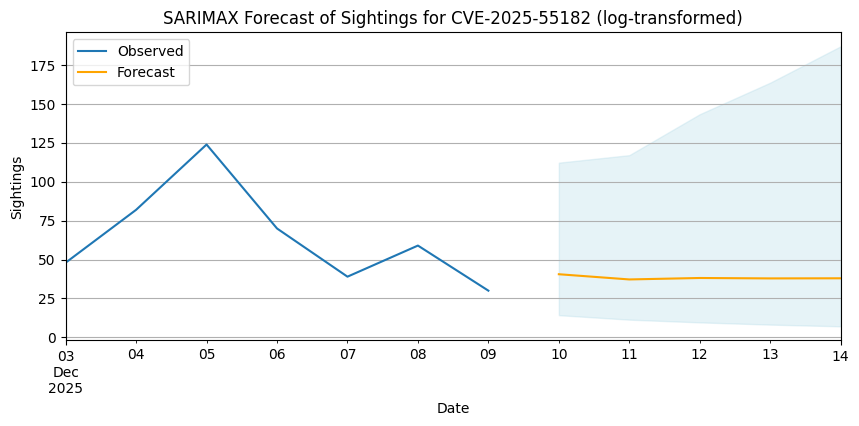

In [18]:
import matplotlib.pyplot as plt

# --- Plot observed + forecast ---
plt.figure(figsize=(10,4))
daily_series.plot(label="Observed")
pred_mean.plot(label="Forecast", color="orange")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color="lightblue", alpha=0.3)
plt.title(f"SARIMAX Forecast of Sightings for {vuln_id} (log-transformed)")
plt.xlabel("Date")
plt.ylabel("Sightings")
plt.legend()
plt.grid(True)
plt.show()